In [37]:
from importlib import reload  
import numpy as np
import matplotlib.pyplot as plt
import pycraf
import cysgp4
from pycraf import conversions as cnv
from pycraf import protection, antenna, geometry
from astropy import units as u, constants as const
from scepter import skynet,obs
from astropy import coordinates as coord
import pandas as pd
import matplotlib.pyplot as plt

In [38]:

###reload here
reload(skynet)
reload(obs)
longitude = coord.Angle("11d55m08s").deg
latitude = coord.Angle("+57d23m35s").deg

elevation = 16 * u.m
ant1=cysgp4.PyObserver(longitude,latitude,elevation.to(u.km).value)
longitude = coord.Angle("11d55m11s").deg
latitude = coord.Angle("+57d23m37s").deg
elevation = 16 * u.m
ant2=cysgp4.PyObserver(longitude,latitude,elevation.to(u.km).value)

In [39]:
bearing_ab,rab= obs.baseline_bearing(ant1,ant2)


In [40]:
niters = 1
pydt = cysgp4.PyDateTime() ## take current date and time
start_times_window = 24 * u.hour
time_range, time_resol = 100*u.s, 1*u.s  # seconds
epochiters=time_range/time_resol

# print(start_times,td)
mjds = skynet.plantime(niters,start_times_window,time_range,time_resol,pydt)
print(mjds.shape)

(1, 1, 1, 1, 100, 1)


In [41]:
###load some tle from starlink
import requests
url = 'https://celestrak.org/NORAD/elements/gp.php?GROUP=starlink&FORMAT=tle'
ctrak_starlink = requests.get(url).text

tle_list = cysgp4.tle_tuples_from_text(ctrak_starlink)

In [42]:
tles = np.array([
    cysgp4.PyTle(*tle) for tle in tle_list
    ])[:500]  # use which TLEs

print (f'we are simulating {tles.shape[0]} satellites over {niters*start_times_window.to_value(u.day)} days,')
print(f'each day/epoch contains {epochiters} integrations over {time_range} seconds')
print(tles.shape)

we are simulating 500 satellites over 1.0 days,
each day/epoch contains 100.0 integrations over 100.0 s seconds
(500,)


In [43]:
min_elevation = -30 * u.deg
grid_size = 3. * u.deg
npoints=1 ##pointing per cell
skygrid = skynet.pointgen(niters=npoints,
    step_size=grid_size,
    lat_range=(min_elevation, 90 * u.deg),
    rnd_seed=0,
    )

tel_az, tel_el, grid_info = skygrid 
print(tel_az.shape)


tx=obs.transmitter_info(p_tx_carrier=-44 * cnv.dBm, carrier_bandwidth=250*u.MHz, duty_cycle=100 * u.percent, d_tx=1*u.m,freq=10.95*u.GHz)
p_tx=tx.power_tx(10.7*u.GHz)
print(p_tx)


(1, 3438)
-27.68556230986828 dB(mW)


In [44]:
dish=13.2*u.m
eta=0.7 *100*u.percent ## in percentage
### frequency band
## transmitter parameters
sat_antenna=0.1*u.m
### observatory list will be passed on internally like this
observers = np.array([ant1,ant2])
rx=obs.receiver_info(dish,eta,observers,freq=10.7*u.GHz,bandwidth=2*u.GHz)

1.2589254117941673 W / (Hz m2)


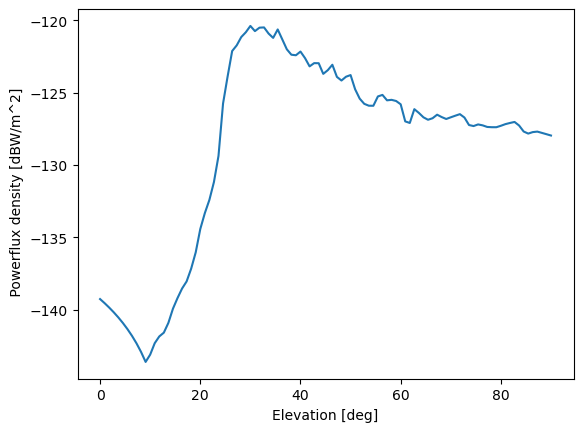

In [45]:
el_response=pd.read_csv('starlink_statistical_pfd.csv')
x_el=el_response['el'].values
y_spfd=el_response['psd_dBW_m2_4khz'].values  ### spectral powerflux density

scale4khz=50e6/4e3 ###4kHz to 1 Hz 
print((1*cnv.dB_W_m2_Hz).to(u.W/u.m**2/u.Hz))
###powerflux_nu = powerflux / bandwidth

y_pfd=(y_spfd*cnv.dB_W_m2_Hz).to(u.W/u.m**2/u.Hz)*(scale4khz*u.Hz) ### powerflux density I think in dB units it's this log factor, maybe should change this methiod
y_pfd=y_pfd.to(cnv.dB_W_m2)
plt.plot(x_el,y_pfd)
plt.ylabel(' Powerflux density [dBW/m^2]')
plt.xlabel('Elevation [deg]')
plt.show()

In [47]:
test=obs.obs_sim(tx,rx,skygrid,mjds)
print(rx.location)
print("array order is observer, pointing per grid, skygrid cells, epochs, time samples per epoch, number of satellites")
print(test.tel_az.shape)

[<PyObserver: 11.9189d, 57.3931d, 0.0160km>
 <PyObserver: 11.9197d, 57.3936d, 0.0160km>]
array order is observer, pointing per grid, skygrid cells, epochs, time samples per epoch, number of satellites
(1, 1, 3438, 1, 1, 1)
